# GW170817: Posterior plot comparison for TaylorF2 with varying PN accuracies

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import bilby
import pandas as pd
import numpy as np
import seaborn as sns
from bilby.gw.result import CBCResult
import matplotlib.lines as mlines
from kde_contour import Bounded_1d_kde, kdeplot_2d_clevels

### Waveforms: TaylorF2-3PN, TaylorF2-3.5PN, TaylorF2-4PN, TaylorF2-4.5PN

In [2]:
rng = np.random.default_rng(12345)

sns.set_theme(palette='colorblind', font_scale=1.5)

nsamples = 3759

result0 = bilby.result.read_in_result("../result_files/TaylorF23PN_fmax1024Hz.hdf5").posterior
result_tf2_3pn = result0.sample(nsamples, random_state=rng)
result_tf2_3pn["templates"] = np.full(len(result_tf2_3pn), "TF2 3PN")
result_tf2_3pn["chirp_mass"] = result_tf2_3pn["chirp_mass"]

result1 = bilby.result.read_in_result("../result_files/TaylorF23p5PN_fmax1024Hz.hdf5").posterior
result_tf2_3p5pn = result1.sample(nsamples, random_state=rng)
result_tf2_3p5pn["templates"] = np.full(len(result_tf2_3p5pn), "TF2 3.5PN")
result_tf2_3p5pn["chirp_mass"] = result_tf2_3p5pn["chirp_mass"]

result2 = bilby.result.read_in_result("../result_files/TaylorF24PN_fmax1024Hz.hdf5").posterior
result_tf2_4pn = result2.sample(nsamples, random_state=rng)
result_tf2_4pn["templates"] = np.full(len(result_tf2_4pn), "TF2 4PN")
result_tf2_4pn["chirp_mass"] = result_tf2_4pn["chirp_mass"]

result3 = bilby.result.read_in_result("../result_files/TaylorF24p5PN_fmax1024Hz.hdf5").posterior
result_tf2_4p5pn = result3.sample(nsamples, random_state=rng)
result_tf2_4p5pn["templates"] = np.full(len(result_tf2_4p5pn), "TF2 4.5PN")
result_tf2_4p5pn["chirp_mass"] = result_tf2_4p5pn["chirp_mass"]


result = pd.concat([result_tf2_3pn, result_tf2_3p5pn, result_tf2_4pn, result_tf2_4p5pn], ignore_index=True)

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    'backend': 'Agg',
    'savefig.dpi': 300,
    'grid.alpha': 0.5,
    'path.simplify': True,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    'mathtext.fontset': 'custom',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,
    'lines.markeredgewidth': 1,
    'legend.numpoints': 1,
    'legend.frameon': False,
    'legend.handletextpad': 0.3
})

lw = 1

def kdeplot2d(x, y, rng=12345, **kws):
    kws.pop('label', None)
    kdeplot_2d_clevels(xs=x, ys=y, auto_bound=True, linewidths=lw, rng=rng, **kws)

def kdeplot1d(x, **kws):
    if np.all(x.isna()):
        return
    for key in ['label', 'hue_order', 'color']:
        kws.pop(key, None)
    df = pd.DataFrame({'x': x, 'y': Bounded_1d_kde(x, xlow=min(x), xhigh=max(x), **kws)(x)})
    df = df.sort_values(['x'])
    plt.fill_between(df['x'], df['y'], np.zeros(len(x)), alpha=0.1)
    plt.plot(df['x'], df['y'], lw=lw)
    plt.xlim(df['x'].min(), df['x'].max())
    current_ymax = plt.ylim()[1]
    if current_ymax > df['y'].max()*1.05:
        plt.ylim(0,current_ymax)
    else:
        plt.ylim(0,df['y'].max()*1.05)

vars = ['chirp_mass', 'mass_ratio']
g = sns.PairGrid(data=result,
                 vars=vars,
                 corner=True, hue="templates",
                 diag_sharey=False,
                 layout_pad=0.,
                 height=2.0,
                )
g.map_lower(kdeplot2d, levels=[0.864,0.393])
g.map_diag(kdeplot1d)
# 14s

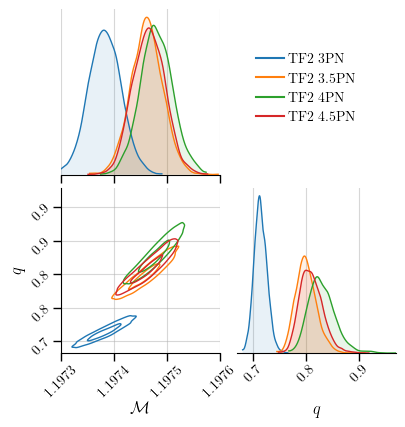

In [4]:
g.axes[1, 1].tick_params(axis='x', rotation=45, pad=1)
g.axes[1, 0].tick_params(axis='x', rotation=45, pad=1)
g.axes[1, 0].tick_params(axis='y', rotation=45, pad=1)

g.axes[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.4f' % x))
g.axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.1f' % x))
g.axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.1f' % x))  

g.axes[1,0].set_xlabel(r'$\mathcal{M}$', labelpad=2, fontsize=12)
g.axes[1,0].set_xlim(1.19730, 1.1976)
g.axes[1,0].set_ylabel(r'$q$', labelpad=4, fontsize=12)
g.axes[1,1].set_xlabel(r'$q$', labelpad=13, fontsize=12)
g.axes[1,1].set_xlim(0.67, 0.97)

# add grid
for i in range(2):
    for j in range(2):
        if g.axes[i, j] is not None:
            g.axes[i, j].grid(True, which="both", ls="-", alpha=0.5)

# add legend with line colors
blue_line = mlines.Line2D([], [], color='C0', label='TF2 3PN')
orange_line = mlines.Line2D([], [], color='C1', label='TF2 3.5PN')
green_line = mlines.Line2D([], [], color='C2', label='TF2 4PN')
red_line = mlines.Line2D([], [], color='C3', label='TF2 4.5PN')
handles = [blue_line, orange_line, green_line, red_line]
labels = [h.get_label() for h in handles] 
g.fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0.9, 0.9, .0), ncol=1) # Adjust loc and ncol as needed

g.savefig("GW170817_TF2_fmax1024Hz.pdf", bbox_inches="tight", dpi=300)
plt.show()